In [6]:
import tensorflow as tf
import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from keras.preprocessing.image import img_to_array, load_img
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, LSTM, Concatenate
from keras import Model, Input


In [7]:
a = np.load('pitch_vector/0/0.npy')
print(a.shape)
print(a)

(1293,)
[ 377.17725 1757.4779  1761.1534  ...  469.21045  217.50768  258.69556]


In [9]:
class CustomSaver(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if np.mod(epoch, 80) ==0 :  # or save after some epoch, each k-th epoch etc.
            self.model.save("feature_fusion_save/model_{}".format(epoch))


In [11]:
# mel spectrogram dataset
path_train = "mel_spectrum_jpg"
num_pic = 0
x = np.zeros([1000, 128, 1280, 3])  # image different size, so only keep 1290
y = np.zeros(1000)
for folder in os.listdir(path_train):
    new_path = os.path.join(path_train, folder)
    for pic in os.listdir(new_path):
        img = load_img(os.path.join(new_path, pic))
        x[num_pic, :, :, :] = img_to_array(img)[:, 0:1280, :]
        y[num_pic] = int(folder)
        num_pic += 1
x = x/255.0
x_clip = x[:, :, 0:128, :]
y_clip = np.copy(y)
for k in range(1, 10):
    x_expand = x[:, :, k*128:(k+1)*128, :]
    x_clip = np.concatenate((x_clip, x_expand), axis=0)
    y_clip = np.concatenate((y_clip, y))

In [36]:
# pitch vector dataset
path_train = "pitch_vector"
num_pic = 0
x = np.zeros([1000, 1280])  # image different size, so only keep 1280
for folder in os.listdir(path_train):
    new_path = os.path.join(path_train, folder)
    for data in os.listdir(new_path):
        pitch = np.load(os.path.join(new_path, data))
        x[num_pic, :] = pitch[0:1280]
        num_pic += 1
x = x/np.max(x, axis=0)
pitch_clip = x[:, 0:128]
for k in range(1, 10):
    pitch_expand = x[:, k*128:(k+1)*128]
    pitch_clip = np.concatenate((pitch_clip, pitch_expand), axis=0)

In [37]:
# training-test dataset splitting
# the same index for mel and pitch
indexes = np.arange(x_clip.shape[0])
train_idx = np.random.choice(indexes, int(x_clip.shape[0]*0.9), replace=False)
test_idx = np.setdiff1d(indexes, train_idx) # find the rest indexes
X_train = x_clip[train_idx,:,:,:]
Y_train = y_clip[train_idx]
Pitch_train = pitch_clip[train_idx,:]
x_test = x_clip[test_idx,:,:,:]
y_test = y_clip[test_idx]
pitch_test = pitch_clip[test_idx,:]

In [41]:
# save the dataset into files, fix the test and train file 
# read 1D/2D savetxt high dimension: np.save read:np.load
# np.save("fusion_data/X_train", X_train)
# np.save("fusion_data/Pitch_train", Pitch_train)
# np.save("fusion_data/Y_train", Y_train)
# np.save("fusion_data/x_test", x_test)
# np.save("fusion_data/pitch_test", pitch_test)
# np.save("fusion_data/y_test", y_test)
X_train = np.load("fusion_data/X_train.npy")
Pitch_train = np.load("fusion_data/Pitch_train.npy")
Y_train = np.load("fusion_data/Y_train.npy")
x_test = np.load("fusion_data/x_test.npy")
pitch_test = np.load("fusion_data/pitch_test.npy")
y_test = np.load("fusion_data/y_test.npy")

In [42]:
# more slices
timesteps = 16
train_slices = np.zeros([np.size(X_train, 0), timesteps, np.size(X_train, 1), int(np.size(X_train, 2)/timesteps), np.size(X_train, 3)])
test_slices = np.zeros([np.size(x_test, 0), timesteps, np.size(X_train, 1), int(np.size(X_train, 2)/timesteps), np.size(X_train, 3)])
train_pitch = np.zeros([np.size(Pitch_train, 0), timesteps, int(np.size(Pitch_train, 1)/timesteps)])
test_pitch = np.zeros([np.size(pitch_test, 0), timesteps, int(np.size(pitch_test, 1)/timesteps)])
for k in range(timesteps):
    train_slices[:, k, :, :, :] = X_train[:, :, int(k*np.size(X_train, 2)/timesteps):int((k+1)*np.size(X_train, 2)/timesteps), :]
    test_slices[:, k, :, :, :] = x_test[:, :, int(k*np.size(X_train, 2)/timesteps):int((k+1)*np.size(X_train, 2)/timesteps), :]
    train_pitch[:, k, :] = Pitch_train[:, int(k*np.size(Pitch_train, 1)/timesteps):int((k+1)*np.size(Pitch_train, 1)/timesteps)]
    test_pitch[:, k, :] = pitch_test[:, int(k*np.size(pitch_test, 1)/timesteps):int((k+1)*np.size(pitch_test, 1)/timesteps)]

# training set and validation set
indexes = np.arange(train_slices.shape[0])
train_idx = np.random.choice(indexes, int(train_slices.shape[0]*0.9), replace=False)
val_idx = np.setdiff1d(indexes, train_idx) # find the rest indexes
x_train = train_slices[train_idx,:,:,:,:]
pitch_train = train_pitch[train_idx,:,:]
y_train = Y_train[train_idx]
x_val = train_slices[val_idx,:,:,:,:]
pitch_val = train_pitch[val_idx,:,:]
y_val = Y_train[val_idx]

In [ ]:
mel_shape = (16, 128, 8, 3)
pitch_shape = (16,8)
input1 = Input(shape=mel_shape)
x2 = TimeDistributed(Conv2D(filters=16, kernel_size=(3, 3), 
                                 padding='same', activation='relu'))(input1)
x3 = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='valid'))(x2)
x4 = Dropout(0.3)(x3)
x5 = TimeDistributed(Conv2D(filters=32, kernel_size=(3, 3), 
                                 padding='same', activation='relu'))(x4)
x6 = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='valid'))(x5)
x7 = Dropout(0.3)(x6)
x8 = TimeDistributed(Conv2D(filters=64, kernel_size=(3, 3), 
                                 padding='same', activation='relu'))(x7)
x9 = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='valid'))(x8)
x10 = Dropout(0.3)(x9)
x11 = TimeDistributed(Flatten())(x10)
x12 = TimeDistributed(Dense(128, activation='relu'))(x11)
input2 = Input(shape=pitch_shape)
l1 = Concatenate(axis=2)([x12,input2])
l2 = LSTM(128, return_sequences=True)(l1)
l2 = Dropout(0.3)(l2)
l3 = LSTM(256)(l2)
l4 = Dropout(0.3)(l3)
l5 = Dense(128, activation='relu')(l4)
l6 = Dropout(0.3)(l5)
output = Dense(10, activation='softmax')(l6)
model = Model([input1, input2], output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss="sparse_categorical_crossentropy",
                metrics='accuracy')
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
saver = CustomSaver()
model.fit(x=[x_train, pitch_train],
        y=y_train,
        epochs=100,
        batch_size=128,
        validation_data=([x_val,pitch_val], y_val),
        shuffle=True,
        callbacks=[tensorboard_callback, saver])

%tensorboard --logdir logs/fit

In [48]:

model = tf.keras.models.load_model("feature_fusion_save/model_100")
tf.keras.utils.plot_model(model, to_file='feature_fusion_save/fusion_model.png', show_shapes=True, show_dtype=True
                          , show_layer_names=False, show_layer_activations=True)
scores = model.evaluate([test_slices, test_pitch] ,y_test)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

32/32 [==============================] - 2s 38ms/step - loss: 0.4921 - accuracy: 0.9000
Test loss: 0.4920535087585449
Test accuracy: 0.8999999761581421


32/32 [==============================] - 1s 33ms/step


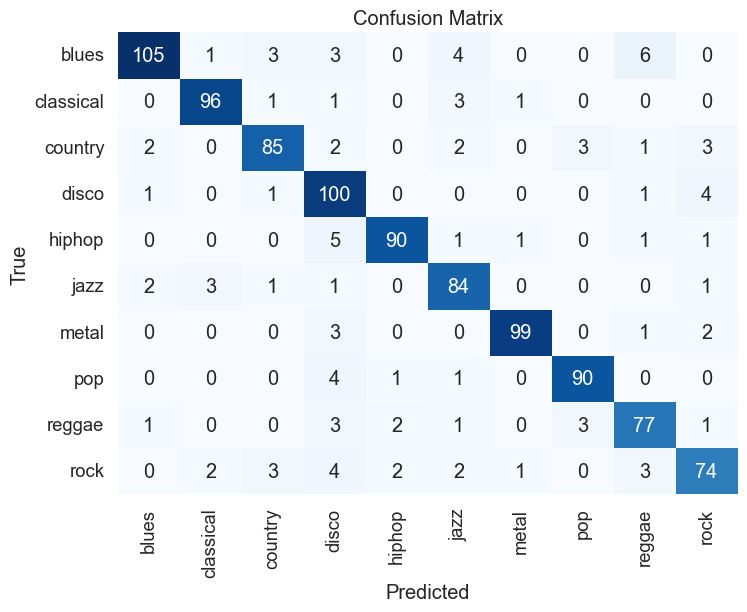

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict([test_slices,test_pitch])
y_pred =np.argmax(y_pred, axis=1)
# define classes
classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

# plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
